In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import time


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# чтение обучающей выборки
df = pd.read_csv('train.tsv',sep='\t')
libs = df.libs
df.head()

,is_virus,filename,libs
0,1,VirusShare_44a578f74f71c566b2ea3702a581bf0d,kernel32.dll
1,1,VirusShare_852c5ccb274e5cac09cbaa0bf6ee9d76,"kernel32.dll,advapi32.dll,comctl32.dll,comdlg3..."
2,1,VirusShare_d7e9e47398dd04225d21fa3afc3acc5a,"msvcrt.dll,kernel32.dll,user32.dll,advapi32.dl..."
3,1,VirusShare_04dee410f3aef6ff2fbbf58cc6a38fbf,"kernel32.dll,user32.dll,gdi32.dll,advapi32.dll..."
4,1,VirusShare_04ce876f84647d16e6ef35a6deae629f,"kernel32.dll,advapi32.dll,msvcrt.dll,user32.dl..."


In [3]:
print(df.shape)

(16290, 3)


In [4]:
df.isnull().values.any()

False

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16290 entries, 0 to 16289
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   is_virus  16290 non-null  int64 
 1   filename  16290 non-null  object
 2   libs      16290 non-null  object
dtypes: int64(1), object(2)
memory usage: 381.9+ KB


In [6]:
# векторизация признаков
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
V = vectorizer.fit_transform(libs)
feature_names = vectorizer.get_feature_names()
X_train = V.toarray()
y_train = df['is_virus'].to_numpy()

In [7]:
print('X train: \n',X_train)
print()
print('y train: \n',y_train)

X train: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

y train: 
 [1 1 1 ... 1 1 0]


In [8]:
# читаем валидационную выборку
dd = pd.read_csv('val.tsv',sep='\t')
libs2 = dd.libs
dd.head()

,is_virus,filename,libs
0,1,2020-02-17T21_09_26+00_00_107385.exe,"kernel32.dll,advapi32.dll,comctl32.dll,gdi32.d..."
1,0,tac.exe,"msys-intl-8.dll,msys-2.0.dll,kernel32.dll"
2,1,VirusShare_eabeaf414d1b87659870918dc7f03f8a,kernel32.dll
3,1,VirusShare_f528efa5b5ba6643b7eb9cf4264d37e4,kernel32.dll
4,1,2019-08-14T00_52_23+00_00_60898.exe,msvbvm60.dll


In [9]:
# векторизация валидационной выборки
V2 = vectorizer.transform(libs2)
X_val = V2.toarray()
y_val = dd['is_virus'].to_numpy()

In [10]:
# читаем тестовую выборку
dd = pd.read_csv('test.tsv',sep='\t')
libs3 = dd.libs
dd.head()

,libs
0,"user32.dll,kernel32.dll"
1,"cygwin1.dll,cygiconv-2.dll,cygintl-8.dll,cygz...."
2,"winmm.dll,tapi32.dll,ws2_32.dll,setupapi.dll,v..."
3,kernel32.dll
4,kernel32.dll


In [11]:
# векторизация тестовой выборки
V3 = vectorizer.transform(libs3)
X_test = V3.toarray()

Text(0.5, 1.0, 'validation data')

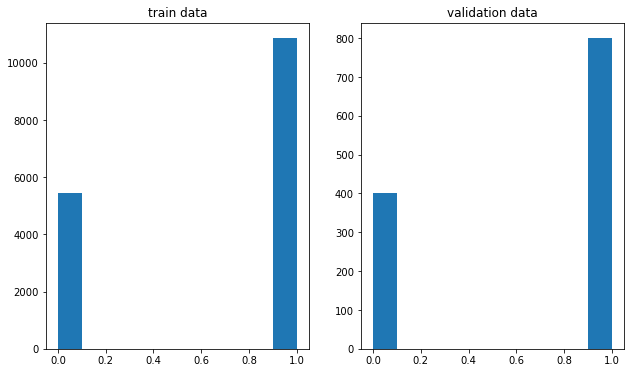

In [12]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,3,1)
pylab.hist(y_train)
pylab.title('train data')

pylab.subplot(1,3,2)
pylab.hist(y_val)
pylab.title('validation data')

## Создание моделей

### RandomForestClassifier

In [13]:
classifier = linear_model.SGDClassifier(random_state=0)

In [14]:
classifier.fit(X_train,y_train)
metrics.mean_absolute_error(y_val, classifier.predict(X_val))

0.135

In [15]:
print(y_val[:20])

[1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1]


In [16]:
print(classifier.predict(X_val)[:20])

[1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1]


In [17]:
classifier.coef_

array([[ 0.        ,  0.03225708, -0.61288444, ...,  0.25805661,
         0.16128538,  0.01612854]])

In [18]:
classifier.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [29]:
parameters_grid = {
    'loss' : ['hinge', 'log', 'squared_hinge', 'squared_loss'],
    'penalty' : ['l1', 'l2'],
    'max_iter' : np.arange(100,1000,30),
    'alpha' : np.linspace(0.0001, 0.001, num = 5)
}

In [30]:
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 0)

In [31]:
randomized_grid_cv = model_selection.RandomizedSearchCV(classifier, parameters_grid, scoring = 'accuracy', cv = cv, n_iter = 20, 
                                                   random_state = 0)

In [ ]:
randomized_grid_cv.fit(X_train, y_train)

In [54]:
# define models and parameters
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
criterion = ['gini', 'entropy']
min_samples_split = [1,2,3,4,5]
min_samples_leaf = [1,2,3,4]

# define random search
random = dict(n_estimators=n_estimators,max_features=max_features,criterion=criterion,
              min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=random, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
random_result = random_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

In [24]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [25]:
rf_predictions_train = rf.predict(X_train)

In [26]:
rf_predictions_val = rf.predict(X_val)
rf_proba_predictions_val = rf.predict_proba(X_val)

In [27]:
type(y_train)

numpy.ndarray

### RidgeClassifier

In [8]:
rc = linear_model.RidgeClassifier()

In [15]:
# define random search
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
random = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
random_search = RandomizedSearchCV(estimator=rc, param_distributions=random, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

start_time = time.time()
random_result = random_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.865275 using {'alpha': 1.0}
0.864273 (0.006453) with: {'alpha': 0.1}
0.864539 (0.006618) with: {'alpha': 0.2}
0.864477 (0.006179) with: {'alpha': 0.3}
0.864764 (0.006094) with: {'alpha': 0.4}
0.864968 (0.006127) with: {'alpha': 0.5}
0.864989 (0.006276) with: {'alpha': 0.6}
0.865091 (0.006211) with: {'alpha': 0.7}
0.865152 (0.006148) with: {'alpha': 0.8}
0.865234 (0.006161) with: {'alpha': 0.9}
0.865275 (0.006103) with: {'alpha': 1.0}
Execution time: 654.9222021102905 ms


In [ ]:
rc.fit(X_train, y_train)

In [ ]:
rc_predictions_train = rc.predict(X_train)

In [372]:
rc_predictions_val = rc.predict(X_val)

In [ ]:
print(rc.coef_)
print(rc.intercept_)
print(metrics.accuracy_score(y_val, rc_predictions_val))

### LogisticRegression

In [32]:
lr = linear_model.LogisticRegression(max_iter=2000)

In [ ]:
# define random search
random = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
random_search = RandomizedSearchCV(estimator=lr, param_distributions=random, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

start_time = time.time()
random_result = random_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [33]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [34]:
lr_predictions_train = lr.predict(X_train)

In [35]:
lr_predictions_val = lr.predict(X_val)
lr_proba_predictions_val = lr.predict_proba(X_val)

### SVC

In [38]:
SVC = SVC()

In [ ]:
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

# define grid search
random = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
random_search = RandomizedSearchCV(estimator=SVC, param_distributions=random, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
random_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [39]:
SVC.fit(X_train, y_train)

SVC()

In [41]:
SVC_predictions_train = SVC.predict(X_train)

KeyboardInterrupt: 

In [ ]:
SVC_predictions_val = SVC.predict(X_val)
SVC_proba_predictions_val = SVC.predict_proba(X_val)

### K-Nearest Neighbors

In [50]:
KNN = KNeighborsClassifier()

In [51]:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# define grid search
random = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

random_search = RandomizedSearchCV(estimator=KNN, param_distributions=random, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
random_result = random_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

In [43]:
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [44]:
KNN_predictions_train = KNN.predict(X_train)

In [45]:
KNN_predictions_val = KNN.predict(X_val)
KNN_proba_predictions_val = KNN.predict_proba(X_val)

## Метрики качества моделей (train)

### RandomForestClassifier

In [46]:
print(metrics.classification_report(y_train, rf_predictions_train))
print(metrics.classification_report(y_val, rf_predictions_val))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5430
           1       0.91      0.99      0.95     10860

    accuracy                           0.93     16290
   macro avg       0.95      0.90      0.92     16290
weighted avg       0.94      0.93      0.93     16290

              precision    recall  f1-score   support

           0       0.94      0.73      0.82       400
           1       0.88      0.98      0.93       800

    accuracy                           0.90      1200
   macro avg       0.91      0.85      0.87      1200
weighted avg       0.90      0.90      0.89      1200



### RidgeClassifier

In [ ]:
print(metrics.classification_report(y_train, rc_predictions_train))
print(metrics.classification_report(y_val, rc_predictions_val))

### LogisticRegression

In [47]:
print(metrics.classification_report(y_train, lr_predictions_train))
print(metrics.classification_report(y_val, lr_predictions_val))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      5430
           1       0.86      0.98      0.91     10860

    accuracy                           0.88     16290
   macro avg       0.90      0.83      0.85     16290
weighted avg       0.88      0.88      0.87     16290

              precision    recall  f1-score   support

           0       0.92      0.67      0.78       400
           1       0.85      0.97      0.91       800

    accuracy                           0.87      1200
   macro avg       0.89      0.82      0.84      1200
weighted avg       0.88      0.87      0.87      1200



### SVC

In [ ]:
print(metrics.classification_report(y_train, SVC_predictions_train))

### K-Nearest Neighbors

In [48]:
print(metrics.classification_report(y_train, KNN_predictions_train))
print(metrics.classification_report(y_val, KNN_predictions_val))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82      5430
           1       0.88      0.97      0.92     10860

    accuracy                           0.89     16290
   macro avg       0.90      0.85      0.87     16290
weighted avg       0.90      0.89      0.89     16290

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       400
           1       0.87      0.97      0.92       800

    accuracy                           0.89      1200
   macro avg       0.90      0.85      0.87      1200
weighted avg       0.89      0.89      0.88      1200



## Метрики качества моделей (val)

### RandomForestClassifier

In [414]:
tn0, fp0, fn0, tp0 = confusion_matrix(y_val, rf_predictions_val).ravel()
print('True positive: {} \nFalse positive: {} \nFalse negative: {} \nTrue negative: {}'.format(tp0,fp0,fn0,tn0))
print('Accuracy: ','{:.4f}'.format(metrics.accuracy_score(y_val, rf_predictions_val)))
print('Precision: ','{:.4f}'.format(metrics.precision_score(y_val, rf_predictions_val)))
print('Recall: ', '{:.4f}'.format(metrics.recall_score(y_val, rf_predictions_val)))
print('F1: ', '{:.4f}'.format(metrics.f1_score(y_val, rf_predictions_val)))
print()
print('Log_loss: ','{:.4f}'.format(metrics.log_loss(y_val, rf_proba_predictions_val[:,1])))

True positive: 784 
False positive: 107 
False negative: 16 
True negative: 293
Accuracy:  0.8975
Precision:  0.8799
Recall:  0.9800
F1:  0.9273

Log_loss:  0.3909


### RidgeClassifier

In [375]:
tn1, fp1, fn1, tp1 = confusion_matrix(y_val, rc_predictions_val).ravel()
print('True positive: {} \nFalse positive: {} \nFalse negative: {} \nTrue negative: {}'.format(tp1,fp1,fn1,tn1))
print('Accuracy: ','{:.4f}'.format(metrics.accuracy_score(y_val, rc_predictions_val)))
print('Precision: ','{:.4f}'.format(metrics.precision_score(y_val, rc_predictions_val)))
print('Recall: ', '{:.4f}'.format(metrics.recall_score(y_val, rc_predictions_val)))
print('F1: ', '{:.4f}'.format(metrics.f1_score(y_val, rc_predictions_val)))

True positive: 781 
False positive: 146 
False negative: 19 
True negative: 254
Accuracy:  0.8625
Precision:  0.8425
Recall:  0.9762
F1:  0.9045


### LogisticRegression

In [381]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_val, lr_predictions_val).ravel()
print('True positive: {} \nFalse positive: {} \nFalse negative: {} \nTrue negative: {}'.format(tp2,fp2,fn2,tn2))
print('Accuracy: ','{:.4f}'.format(metrics.accuracy_score(y_val, lr_predictions_val)))
print('Precision: ','{:.4f}'.format(metrics.precision_score(y_val, lr_predictions_val)))
print('Recall: ', '{:.4f}'.format(metrics.recall_score(y_val, lr_predictions_val)))
print('F1: ', '{:.4f}'.format(metrics.f1_score(y_val, lr_predictions_val)))
print()
print('Log_loss: ','{:.4f}'.format(metrics.log_loss(y_val, lr_proba_predictions_val[:,1])))

True positive: 778 
False positive: 132 
False negative: 22 
True negative: 268
Accuracy:  0.8717
Precision:  0.8549
Recall:  0.9725
F1:  0.9099

Log_loss:  0.3247


### SVC

In [ ]:
tn3, fp3, fn3, tp3 = confusion_matrix(y_val, SVC_predictions_val).ravel()
print('True positive: {} \nFalse positive: {} \nFalse negative: {} \nTrue negative: {}'.format(tp3,fp3,fn3,tn3))
print('Accuracy: ','{:.4f}'.format(metrics.accuracy_score(y_val, SVC_predictions_val)))
print('Precision: ','{:.4f}'.format(metrics.precision_score(y_val, SVC_predictions_val)))
print('Recall: ', '{:.4f}'.format(metrics.recall_score(y_val, SVC_predictions_val)))
print('F1: ', '{:.4f}'.format(metrics.f1_score(y_val, SVC_predictions_val)))
print()
print('Log_loss: ','{:.4f}'.format(metrics.log_loss(y_val, SVC_proba_predictions_val[:,1])))

### K-Nearest Neighbors

In [ ]:
tn4, fp4, fn4, tp4 = confusion_matrix(y_val, KNN_predictions_val).ravel()
print('True positive: {} \nFalse positive: {} \nFalse negative: {} \nTrue negative: {}'.format(tp4,fp4,fn4,tn4))
print('Accuracy: ','{:.4f}'.format(metrics.accuracy_score(y_val, KNN_predictions_val)))
print('Precision: ','{:.4f}'.format(metrics.precision_score(y_val, KNN_predictions_val)))
print('Recall: ', '{:.4f}'.format(metrics.recall_score(y_val, KNN_predictions_val)))
print('F1: ', '{:.4f}'.format(metrics.f1_score(y_val, KNN_predictions_val)))
print()
print('Log_loss: ','{:.4f}'.format(metrics.log_loss(y_val, KNN_proba_predictions_val[:,1])))

## Построение прогнозов по тестовой выборке

In [346]:
# RidgeClassifier
rc_predictions_test = rc.predict(X_test)
print(rc_predictions_test)

[1 0 0 ... 1 1 1]


In [347]:
# LogisticRegression
lr_predictions_test = lr.predict(X_test)
print(lr_predictions_test)

[1 0 0 ... 1 1 1]


In [348]:
# SVC Classifier
SVC_predictions_test = SVC.predict(X_test)
print(SVC_predictions_test)

[1 0 0 ... 1 1 1]
